## **Importing Modules**

In [ ]:
#importing required modules

import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve


## **Data Preprocessing**

In [ ]:
#importing data

#Dataset address
url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
output = 'data.zip'
gdown.download(url, output, quiet=False)

#giving zip file name
data_dir='./data.zip'

#extractng data from zip file
with zipfile.ZipFile(data_dir, 'r') as zf:
    zf.extractall('./data')
    print('Done downloading and extraction')

#removing zip file after extraction
!rm './data.zip' 

#invstigating number of files
orange_files = np.array(glob("/content/data/*/*/*"))
print('There are %d total chest xray images.' % len(orange_files))

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

Downloading...
From: https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY
To: /content/data.zip
100%|██████████| 46.1M/46.1M [00:00<00:00, 80.1MB/s]


Done downloading and extraction
There are 4626 total chest xray images.


In [ ]:
transform = T.Compose([T.ToTensor(),])
orange_file='./data/'

train_path=os.path.join(orange_file,'train')
dataset = datasets.ImageFolder(train_path,transform=transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    if (i == 0): size = data.size(1) * data.size(2)
    mean += data.sum((1, 2)) / size

mean /= len(dataloader)
print(mean)
mean = mean.unsqueeze(1).unsqueeze(2)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    std += ((data - mean) ** 2).sum((1, 2)) / size

std /= len(dataloader)
std = std.sqrt()
print(std)

0
tensor([0.5219, 0.5220, 0.5223])
0
tensor([0.2476, 0.2476, 0.2477])


In [ ]:
#declaring batch size
batch_size = 16

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
       
        T.RandomCrop(size=(224,224)), 
        T.ToTensor(),
        T.Normalize((0.5219, 0.5220, 0.5223), (0.2476, 0.2476, 0.2477)),
    ]),
    

    'valid':
    T.Compose([
          
        T.RandomCrop(size=(224,224)),
        T.ToTensor(),
        T.Normalize((0.5219, 0.5220, 0.5223), (0.2476, 0.2476, 0.2477)),
    ]),


    'test':
    T.Compose([
              
        T.RandomCrop(size=(224,224)),
        T.ToTensor(),
        T.Normalize((0.5219, 0.5220, 0.5223), (0.2476, 0.2476, 0.2477)),
    ]),
}


#  creating Location of data: train, validation, test
orange_file='./data/'

train_path=os.path.join(orange_file,'train')
valid_path=os.path.join(orange_file,'valid')
test_path=os.path.join(orange_file,'test')


# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#Creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=False)
}

## **Model Building**

In [ ]:
#Creating the CNN architecture

model_transfer = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Defining second 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            # Defining third 2D convolution layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Defining fourth 2D convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            
            # Defining fifth 2D convolution layer
            nn.Conv2d(256, 320, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(320),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Defining sixth 2D convolution layer
            nn.Conv2d(320, 320, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(320),
            nn.LeakyReLU(inplace=True),
            
            # Defining seventh 2D convolution layer
            nn.Conv2d(320, 484, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(484),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Defining eigth 2D convolution layer
            nn.Conv2d(484, 484, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(484),
            nn.LeakyReLU(inplace=True),

            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(14*14*484,1024),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024,1024),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024,2),
      
            nn.Sigmoid(),
          )

if use_cuda:
    model_transfer = model_transfer.cuda()
    

In [ ]:
model_transfer

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01, inplace=True)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.01, inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): LeakyReLU(neg

In [ ]:
summary(model_transfer, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         LeakyReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
         LeakyReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
        LeakyReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
      BatchNorm2d-13          [-1, 256, 56, 56]             512
        LeakyReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#using Adam optimizer
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0001)

## **Training and Validating the Model**



In [ ]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct1 = 0.
        total1 = 0.
        correct2 = 0.
        total2 = 0.

        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct1 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total1 += data.size(0)

       
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct2 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total2 += data.size(0)

      

        train_loss = train_loss/len(train_file)
        valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)
        acc1 = 100. * correct1 / total1
        acc2 =  100. * correct2 / total2
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.4f}'.format(
            epoch,
            train_loss,
            acc1,
            valid_loss,
            acc2
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [ ]:
# training the model

n_epochs=50

model, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, './model_transfer.pt')

Epoch: 1 	Training Loss: 0.000141 	Training Accuracy: 78.4711 	Validation Loss: 0.001196 	Validation Accuracy: 75.7576
Validation loss decreased (inf --> 0.001196).  Saving model ...
Epoch: 2 	Training Loss: 0.000130 	Training Accuracy: 82.7391 	Validation Loss: 0.000969 	Validation Accuracy: 87.4459
Validation loss decreased (0.001196 --> 0.000969).  Saving model ...
Epoch: 3 	Training Loss: 0.000127 	Training Accuracy: 83.9546 	Validation Loss: 0.001178 	Validation Accuracy: 76.4069
Epoch: 4 	Training Loss: 0.000128 	Training Accuracy: 83.3603 	Validation Loss: 0.001168 	Validation Accuracy: 76.8398
Epoch: 5 	Training Loss: 0.000131 	Training Accuracy: 82.4419 	Validation Loss: 0.000964 	Validation Accuracy: 87.0130
Validation loss decreased (0.000969 --> 0.000964).  Saving model ...
Epoch: 6 	Training Loss: 0.000129 	Training Accuracy: 83.2253 	Validation Loss: 0.001141 	Validation Accuracy: 76.4069
Epoch: 7 	Training Loss: 0.000126 	Training Accuracy: 83.4144 	Validation Loss: 0.00

In [ ]:

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('./model_transfer.pt'))

<All keys matched successfully>

##  **Testing the Model**



In [ ]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.7f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.4424002


Test Accuracy: 87% (404/462)


## **Visulizing the results**

In [ ]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

Confusion Matrix:
 [[218  45]
 [ 13 186]]


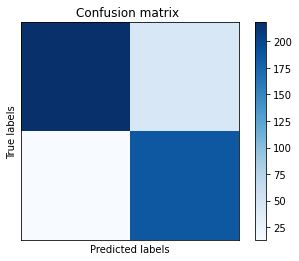

In [ ]:

#plotting the confusion matrix for testing data

cm = confusion_matrix(preds2, targets2)
print('Confusion Matrix:\n', cm)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

AUC score:  0.8744588744588745
Accuracy:  0.8744588744588745
F1 score:  0.8651162790697674
Precision score:  0.9346733668341709
Recall score:  0.8051948051948052


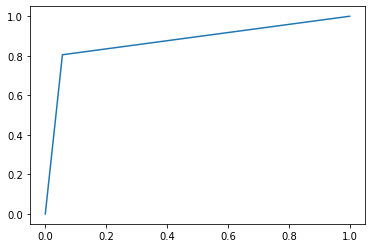

In [ ]:
#Computing the 5 evaluation metrics and printing

acc = accuracy_score(targets2, preds2)

fpr, tpr, _ = roc_curve(targets2, preds2)

area = roc_auc_score(targets2, preds2)
print("AUC score: ", area)

print("Accuracy: ", acc)

f1 = f1_score(targets2, preds2)
print("F1 score: ", f1)

pre = precision_score(targets2, preds2)
print("Precision score: ", pre)

recall = recall_score(targets2, preds2)
print("Recall score: ", recall)

plt.plot(fpr, tpr)

Text(0, 0.5, 'loss')

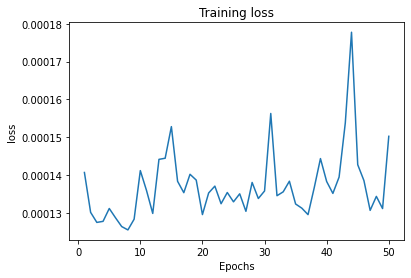

In [ ]:
#Plotting the training loss

plt.plot(range(1,1+n_epochs),train_loss)
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

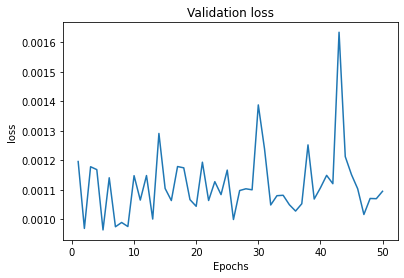

In [ ]:
#Plotting the validation loss

plt.plot(range(1,1+n_epochs),valid_loss)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")